<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from pandas.api.types import is_numeric_dtype

In [159]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed


In [160]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model



In [161]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load Original Dataset

In [162]:
dataset_url = "https://github.com/ipeirotis/autoencoders_census/raw/main/sadc_2017only_national_full.csv"
original_df = pd.read_csv(dataset_url)


In [163]:
original_df.head()

,sitecode,sitename,sitetype,sitetypenum,year,survyear,weight,stratum,PSU,record,...,qnwenthungry,qnmusclestrength,qnsunscreenuse,qnindoortanning,qnsunburn,qnconcentrating,qncurrentasthma,qnwheresleep,qnspeakenglish,qntransgender
0,XX,United States (XX),National,3,2017,14,2.4095,111,171190,1509749,...,NaN,1.0,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN
1,XX,United States (XX),National,3,2017,14,1.6614,212,170890,1509750,...,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,NaN
2,XX,United States (XX),National,3,2017,14,0.7049,212,170890,1509751,...,NaN,2.0,NaN,2.0,2.0,2.0,NaN,NaN,1.0,NaN
3,XX,United States (XX),National,3,2017,14,0.7966,212,170890,1509752,...,NaN,1.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN
4,XX,United States (XX),National,3,2017,14,1.9776,202,160270,1509753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
columns_to_drop = ['sitecode', 'sitename', 'sitetype', 'sitetypenum', 'year', 'survyear', 'record', 'stratum', 'PSU']
original_df = original_df.drop(columns = columns_to_drop, axis='columns')

In [165]:
original_df.shape

(14765, 305)

# Transforming the original data set

## Dropping uneccessary columns

We only reserve columns of questionnaire questions and other necessary information such as students' height, students' weight, age, sex, etc.

In [166]:
project_data = original_df.iloc[:, :100]
project_data.shape

(14765, 100)

Our dataset contains 14765 observations and 110 raw features.

In [167]:
# The dataframe contains separate questionnaire questions, here we merge these columns to our project dataframe

lst = [216, 232, 242, 245, 247, 249, 251, 252, 253, 256]
project_data = pd.concat([project_data, original_df.iloc[:, lst]], axis=1)
project_data.head()

,weight,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qpropertydamage,qgenderexp,qsugardrink,qfoodallergy,qmusclestrength,qindoortanning,qconcentrating,qcurrentasthma,qwheresleep,qnbikehelmet
0,2.4095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Not sure,3 days,0 times,Yes,NaN,NaN,NaN
1,1.6614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Not sure,4 days,0 times,Yes,NaN,NaN,NaN
2,0.7049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,1 day,0 times,No,NaN,NaN,NaN
3,0.7966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,3 days,0 times,No,NaN,NaN,NaN
4,1.9776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN


Set more specific names for each column.

In [168]:
rename_columns = {
    "age": "age",
    "sex": "sex",
    "grade": "grade",
    "race4": "Hispanic_or_Latino",
    "race7": "race",
    "qnobese": "obese",
    "qnowt": "overweight",
    "q67": "sexual_identity",
    "q66": "sex/sexual_contacts",
    "sexid": "sexid",
    "sexid2": "sexid2",
    "sexpart": "sexpart",
    "sexpart2": "sexpart2",
    "q8": "seat_belt_use",
    "q9": "riding_with_a_drinking_driver",
    "q10": "drinking_and_driving",
    "q11": "texting_and_driving",
    "q12": "weapon_carrying",
    "q13": "weapon_carrying_at_school",
    "q14": "gun_carrying_past_12_mos",
    "q15": "safety_concerns_at_school",
    "q16": "threatened_at_school",
    "q17": "physical_fighting",
    "q18": "physical_fighting_at_school",
    "q19": "forced_sexual_intercourse",
    "q20": "sexual_violence",
    "q21": "sexual_dating_violence",
    "q22": "physical_dating_violence",
    "q23": "bullying_at_school",
    "q24": "electronic_bullying",
    "q25": "sad_or_hopeless",
    "q26": "considered_suicide",
    "q27": "made_a_suicide_plan",
    "q28": "attempted_suicide",
    "q29": "injurious_suicide_attempt",
    "q30": "ever_cigarette_use",
    "q31": "initation_of_cigarette_smoking",
    "q32": "current_cigarette_use",
    "q33": "smoking_amounts_per_day",
    "q34": "electronic_vapor_product_use",
    "q35": "current_electronic_vapor_product_use",
    "q36": "EVP_from_store",
    "q37": "current_smokeless_tobacco_use",
    "q38": "current_cigar_use",
    "q39": "all_tobacco_product_cessation",
    "q40": "ever_alcohol_use",
    "q41": "initiation_of_alcohol_use",
    "q42": "current_alcohol_use",
    "q43": "source_of_alcohol",
    "q44": "current_binge_drinking",
    "q45": "largest_number_of_drinks",
    "q46": "ever_marijuana_use",
    "q47": "initiation_of_marijuana_use",
    "q48": "current_marijuana_use",
    "q49": "ever_cocaine_use",
    "q50": "ever_inhalant_use",
    "q51": "ever_heroin_use",
    "q52": "ever_methamphetamine_use",
    "q53": "ever_ecstasy_use",
    "q54": "ever_synthetic_marijuana_use",
    "q55": "ever_steroid_use",
    "q56": "ever_prescription_pain_medicine_use",
    "q57": "illegal_injected_drug_use",
    "q58": "illegal_drugs_at_school",
    "q59": "ever_sexual_intercourse",
    "q60": "first_sex_intercourse",
    "q61": "multiple_sex_partners",
    "q62": "current_sexual_activity",
    "q63": "alcohol/drugs_at_sex",
    "q64": "condom_use",
    "q65": "birth_control_pill_use",
    "q68": "perception_of_weight",
    "q69": "weight_loss",
    "q70": "fruit_juice_drinking",
    "q71": "fruit_eating",
    "q72": "green _salad_eating",
    "q73": "potato_eating",
    "q74": "carrot_eating",
    "q75": "other_vegetable_eating",
    "q76": "soda_drinking",
    "q77": "milk_drinking",
    "q78": "breakfast_eating",
    "q79": "physical_activity",
    "q80": "television_watching",
    "q81": "computer_not_school_work_use",
    "q82": "PE_attendance",
    "q83": "sports_team_participation",
    "q84": "concussion_in_last_12_mos",
    "q85": "HIV_testing",
    "q86": "oral_health_care",
    "q87": "asthma",
    "q88": "sleep_on_school_night",
    "q89": "grades_in_school",
    "qdrivemarijuana": "drive_when_using_marijuana",
    "qhallucdrug": "ever_used_LSD",
    "qsportsdrink": "sports_drinks",
    "qwater": "plain_water",
    "qfoodallergy": "food_allergies",
    "qmusclestrength": "muscle_stregthening",
    "qindoortanning": "indoor_tanning",
    "qsunburn": "sunburn",
    "qconcentrating": "difficulty_concentrating",
    "qspeakenglish": "how_well_speak_English",
}

In [169]:
project_data.rename(columns=rename_columns, inplace = True)

In [170]:
project_data['obese'] = project_data['obese'].replace({1: 'obese', 2: 'not obese'})
project_data['overweight'] = project_data['overweight'].replace({1: 'overweight', 2: 'not overweight'})

## Analysis of Missing Values

In [171]:
project_data.isnull().sum()

weight                          0
age                            81
sex                           127
grade                         144
Hispanic_or_Latino            337
                            ...  
indoor_tanning               1751
difficulty_concentrating     4097
qcurrentasthma              14765
qwheresleep                 14765
qnbikehelmet                14765
Length: 110, dtype: int64

Several columns have a significant number of missing values (the missing percentage is greater than 25%).

In [172]:
missing_percentages = project_data.isnull().mean() * 100
columns_with_missing_gt_25 = missing_percentages[missing_percentages > 25].index

# Select the columns with missing values > 25%
# selected_columns = df1[columns_with_missing_gt_25]

# Print the selected columns
columns_with_missing_gt_25

Index(['attempted_suicide', 'injurious_suicide_attempt',
       'all_tobacco_product_cessation', 'source_of_alcohol',
       'largest_number_of_drinks', 'qpropertydamage', 'qgenderexp',
       'qsugardrink', 'food_allergies', 'muscle_stregthening',
       'difficulty_concentrating', 'qcurrentasthma', 'qwheresleep',
       'qnbikehelmet'],
      dtype='object')

There are missing values in the dataset, to handle them will make use of adding missing value indicator columns. We will not use mean or median to fill the missing cell as it may affect the model.

Separate numerical columns and categorical columns for further normalization operations.

In [173]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]

In [174]:
categorical_vars = [c for c in project_data.columns.values if c not in numeric_vars]

## Code that transforms a dataframe to vector format and vice versa




Transform and reverse transform the data, allowing for preprocessing and postprocessing steps in pipelines. It provides functionality to handle missing values, encode categorical variables, and scale numeric variables.

In [175]:
def transform_dataframe(df, variable_types):

    # Add dummies for missing values
    df_missing = pd.concat([df[c].isnull().astype(int) for c in df.columns], axis = 1)
    df_missing.columns = [f'{c}_missing' for c in df.columns]
    df = pd.concat([df, df_missing], axis='columns')

    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    one_hot_encoders = {}
    one_hot_columns = []

    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    min_max_scalers = {}

    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            # one_hot_encoder.set_output(transform='pandas')
            df_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[[column]]))
            df_encoded.columns = [f"{column}_{cat}" for cat in one_hot_encoder.categories_[0]]
            one_hot_columns.append(df_encoded)
            df = pd.concat([df, df_encoded], axis=1)
            df = df.drop(column, axis=1)
            one_hot_encoders[column] = one_hot_encoder
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            min_max_scaler = MinMaxScaler()
            df[column] = min_max_scaler.fit_transform(df[[column]])
            min_max_scalers[column] = min_max_scaler
    

    
    # original_cat_cols = [c for c in variable_types if variable_types[c] == 'categorical' ]
    # df = df.drop(original_cat_cols, axis='columns')

    return df, one_hot_encoders, min_max_scalers



def proba_to_onehot(proba):
    '''
    Takes as input a vector of probabilities and converts it into 
    a max-likelihood one-hot vector
    '''
    onehot = np.zeros_like(proba)
    onehot[np.arange(len(proba)), np.argmax(proba, axis=1)] = 1
    return onehot

def reverse_transform_dataframe(df, variable_types, one_hot_encoders, min_max_scalers):
    for column, variable_type in variable_types.items():
        if variable_type == 'categorical':
            one_hot_encoder = one_hot_encoders[column]
            original_cols = [col for col in df.columns if col.startswith(f"{column}_")]
            df_proba = df[original_cols].values
            onehot = proba_to_onehot(df_proba)
            df_original = pd.DataFrame(one_hot_encoder.inverse_transform(onehot))
            df_original.columns = [column]
            df = pd.concat([df.drop(original_cols, axis=1), df_original], axis=1)
        elif variable_type == 'numeric' and is_numeric_dtype(df[column]):
            min_max_scaler = min_max_scalers[column]
            df[column] = min_max_scaler.inverse_transform(df[[column]])

    return df

In [176]:
variable_types = {}
for column in numeric_vars:
    variable_types[column] = 'numeric'

for column in categorical_vars:
    variable_types[column] = 'categorical'

transformed_df, one_hot_encoder, min_max_scaler = transform_dataframe(project_data, variable_types)

In [177]:
transformed_df.shape

(14765, 746)

# Autoencoder training

## Architecture setup

In [178]:
latent_dimension = 1
batch_size = 20

hidden_nodes = 16

# The dimensionality of the dataframe is (nrows x dim).
# We keep the dim as the size of the input
input_dim = transformed_df.shape[1]

input_encoder = Input(shape=(input_dim,), name="Input_Encoder")

batch_normalize1 = BatchNormalization()(input_encoder)

hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Encoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(hidden_layer)

z = Dense(latent_dimension, name="Mean")(batch_normalize2)

Define and create the encoder model.

In [179]:
encoder = Model(input_encoder, z, name="Encoder")

Define the decoder part of the autoencoder model. It's responsible for reconstructing the original input data from the compressed representation.

In [180]:
input_decoder = Input(shape=(latent_dimension,), name="Input_Decoder")
batch_normalize1 = BatchNormalization()(input_decoder)

decoder_hidden_layer = Dense(hidden_nodes, activation="relu", name="Hidden_Decoding")(
    batch_normalize1
)
batch_normalize2 = BatchNormalization()(decoder_hidden_layer)

decoded = Dense(input_dim, activation="linear", name="Decoded")(batch_normalize2)

In [181]:
decoder = Model(input_decoder, decoded, name="Decoder")

Combine the encoder and decoder models to create the complete autoencoder architecture.

In [182]:
encoder_decoder = decoder(encoder(input_encoder))

ae = Model(input_encoder, encoder_decoder)

ae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Encoder (InputLayer)  [(None, 746)]             0         
                                                                 
 Encoder (Functional)        (None, 1)                 15017     
                                                                 
 Decoder (Functional)        (None, 746)               12782     
                                                                 
Total params: 27,799
Trainable params: 26,241
Non-trainable params: 1,558
_________________________________________________________________


## Train the Model 

The training of an autoencoder model while effectively handling missing data with mask variables.

In [183]:
def masked_mse(y_true, y_pred):
    mask = tf.where(tf.math.is_nan(y_true), 0.0, 1.0)
    return tf.reduce_mean(tf.square(y_true - y_pred) * mask)

ae.compile(loss=masked_mse, optimizer="adam", weighted_metrics=[])

# Replace null values in the dataframe with zeros
transformed_df = transformed_df.fillna(0.0)

mask = np.where(transformed_df.isnull(), 0.0, 1.0)
mask = np.expand_dims(mask, axis=-1)

# Initialize lists to track losses
train_loss = []
val_loss = []

class LossTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs.get('loss'))
        val_loss.append(logs.get('val_loss'))

loss_tracker = LossTracker()

history = ae.fit(
    transformed_df, transformed_df, sample_weight=mask, shuffle=True, epochs=10, batch_size=20,
    validation_split=0.2, verbose=0, callbacks=[loss_tracker]
)

## Examine Training Output Statistics

Visualize the training and validation loss values over epochs.

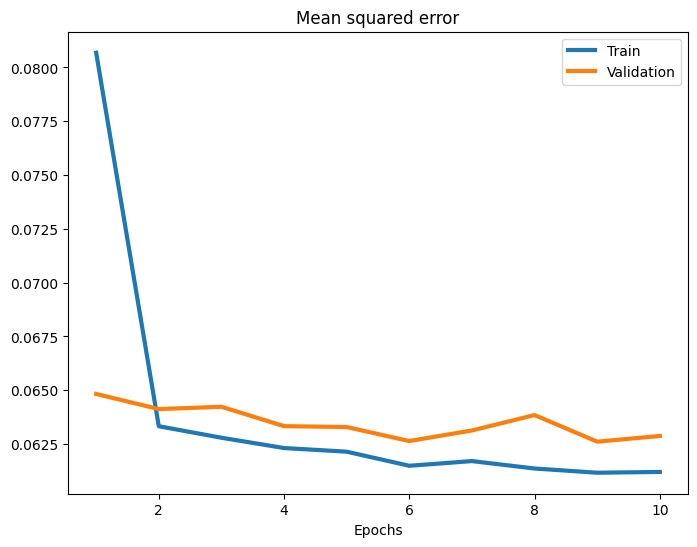

Training MSE = 0.2473896586333563
Validation MSE = 0.2507470265028675


In [184]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.savefig("FirstNet.png", dpi=400)
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(train_loss, val_loss)

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 1ms/step


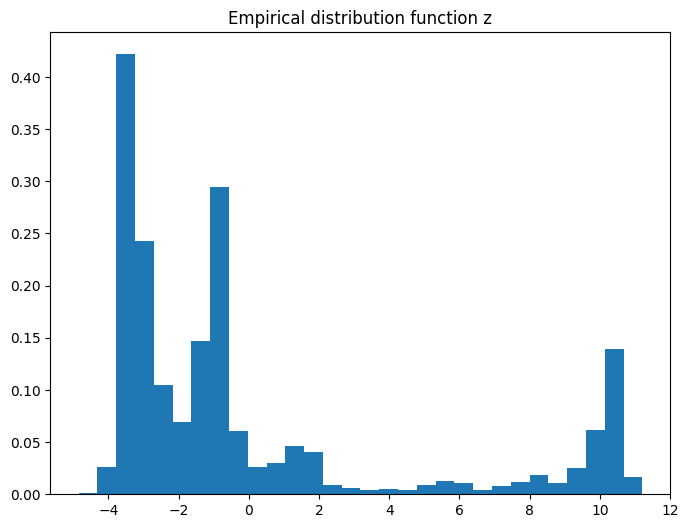

In [185]:
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14))
# use the encoder model to obtain the latent representation (z) of the data input
plt.hist(encoder.predict(transformed_df), bins=30, density=True)
plt.savefig("DistInternal.png", dpi=400)

In [ ]:
ae.predict(transformed_df)[0,:]

Visualize the empirical cumulative distribution function (ECDF) of the first dimension of the latent representation obtained from the encoder model.

462/462 [==============================] - 1s 1ms/step


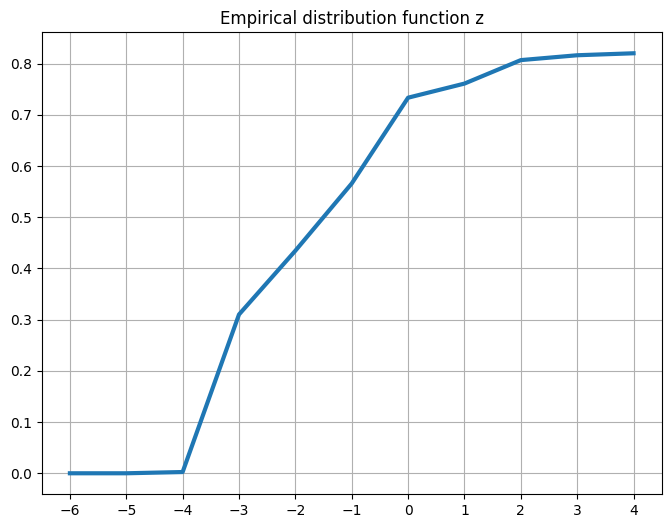

In [187]:
ecdf = ECDF(encoder.predict(transformed_df)[:, 0])
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(x)
plt.grid()
plt.plot(x, ecdf(x), linewidth=3)
plt.savefig("EmpiricalDF.png", dpi=400)

Visualize the inverted empirical distribution function based on the sample EDF values and their corresponding x-values.

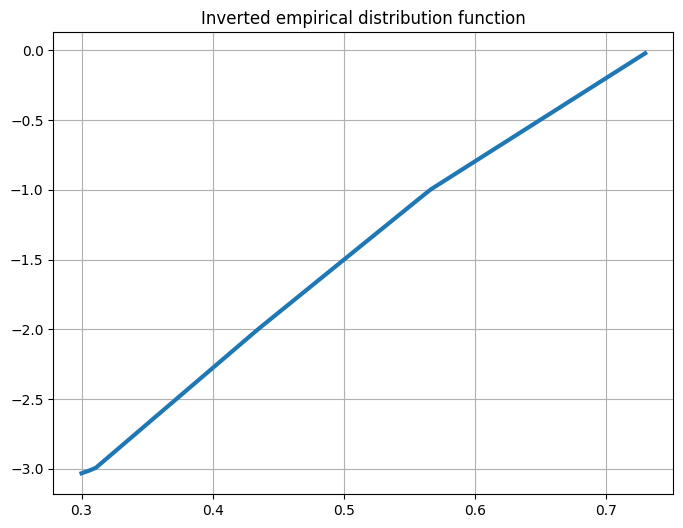

In [188]:
x = (-6,-5, -4, -3, -2, -1, 0, 1, 2, 3, 4)
# calculate the sample EDF values at the specified x-values
sample_edf_values_at_slope_changes = [ecdf(i) for i in x]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, x)

# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Inverted empirical distribution function")
x = np.linspace(0.30, 0.73, 80)
plt.xticks(np.linspace(0, 1.0, 11))
plt.grid()
plt.plot(x, inverted_edf(x), linewidth=3)
plt.savefig("InvertedEmpiricalDF.png", dpi=400)

Generate random values from a specific distribution that resembles the original data distribution using the inverted empirical distribution function.

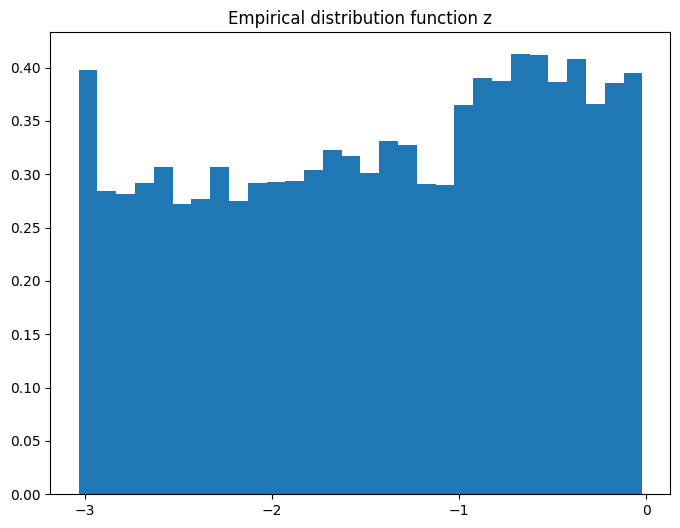

In [189]:
# number of data points to generate
N = 10000
seed(2021)
plt.figure(figsize=(8, 6))
plt.title("Empirical distribution function z")
plt.xticks((-5, -4, -3, -2, -1, 0, 1, 2, 3, 4))
# N random values from a uniform distribution are transformed to follow a specific distribution using the inverted EDF
plt.hist(inverted_edf(uniform(0.30, 0.73, N)), bins=30, density=True)
plt.savefig("DistGenerated.png", dpi=400)

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 1ms/step


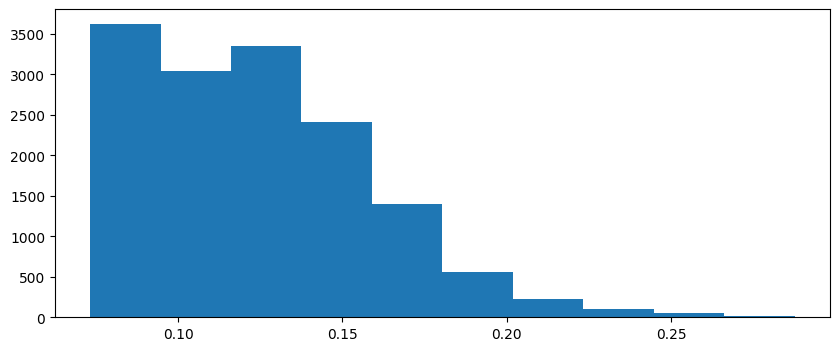

In [190]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = ae.predict(transformed_df)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions, transformed_df)
plt.hist(normal_loss, bins=10)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [191]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.19277262502417986


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

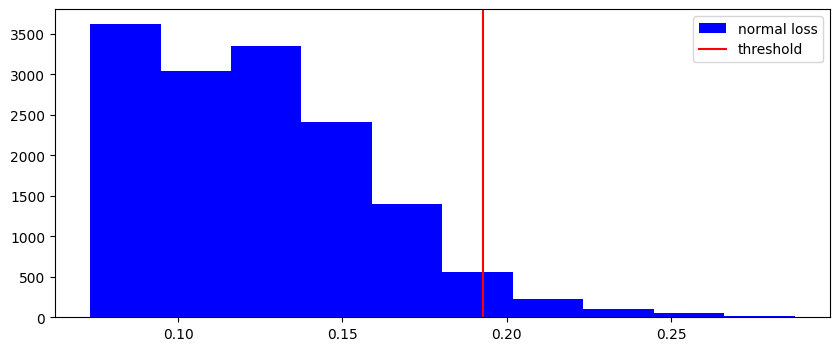

In [192]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=10, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

Obtain the indices in descending order of the reconstruction errors.

In [193]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [194]:
k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic_or_Latino_missing,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
129,0.046169,0.0,0.0,0.000000,0.0,0,1,0,0,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
7167,0.286784,0.0,0.0,0.000000,0.0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7248,0.353671,0.0,0.0,0.000000,0.0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
100,0.055313,0.0,0.0,0.140038,0.0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
29,0.638196,0.0,0.0,0.157129,0.0,0,1,1,1,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [195]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic_or_Latino_missing,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
7,0.356232,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
12,0.211872,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
15,0.043351,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
18,0.396248,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
22,0.243433,0.0,0.0,0.0,0.0,0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [196]:
anomaly_tuples.shape

(560, 746)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [197]:
ae.compile(loss="mean_squared_error", optimizer="adam")

reconstructed_data = ae.predict(transformed_df)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 1s 1ms/step


,weight,stheight,stweight,bmi,bmipct,weight_missing,age_missing,sex_missing,grade_missing,Hispanic_or_Latino_missing,...,indoor_tanning_20 to 39 times,indoor_tanning_3 to 9 times,indoor_tanning_40 or more times,indoor_tanning_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan
0,0.508875,NaN,NaN,NaN,NaN,0,1,1,1,1,...,-0.000873,0.003327,0.011996,0.034004,0.612780,0.328245,0.100314,1.030127,1.031021,1.031437
1,0.347927,NaN,NaN,NaN,NaN,0,1,1,1,1,...,-0.026381,-0.003481,-0.005411,0.129656,0.653257,0.168501,0.216217,1.021641,1.024097,1.025799
2,0.142144,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.005865,0.003468,0.019967,0.020627,0.597739,0.362640,0.078047,1.029821,1.031381,1.029556
3,0.161873,NaN,NaN,NaN,NaN,0,1,1,1,1,...,0.015810,0.018799,0.015899,0.050750,0.551431,0.348660,0.098429,0.989818,0.988823,0.992610
4,0.415955,NaN,NaN,NaN,NaN,0,1,1,1,1,...,-0.024254,-0.002913,-0.003960,0.121680,0.649881,0.181821,0.206553,1.022348,1.024675,1.026269


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [198]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

<ipython-input-198-9a1a964cdb25>:9: RuntimeWarning: divide by zero encountered in double_scalars
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)


Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [199]:
auc_scores = {}

for column in mapped_categories:
    
    mapped_values = mapped_categories[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)
    
    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

{'weight_missing': nan,
 'age_missing': 0.5,
 'sex_missing': 0.5,
 'grade_missing': 0.5,
 'Hispanic_or_Latino_missing': 0.5,
 'race_missing': 0.5,
 'stheight_missing': 0.5492864054355292,
 'stweight_missing': 0.5581808128729966,
 'bmi_missing': 0.5607519741692237,
 'bmipct_missing': 0.5513306536830109,
 'obese_missing': 0.5659946820461832,
 'overweight_missing': 0.5604932046958344,
 'sexual_identity_missing': 0.9018988222621835,
 'sex/sexual_contacts_missing': 0.5,
 'sexid_missing': 0.8991363212858061,
 'sexid2_missing': 0.8991363212858061,
 'sexpart_missing': 0.5,
 'sexpart2_missing': 0.5,
 'seat_belt_use_missing': 0.6095820364956218,
 'riding_with_a_drinking_driver_missing': 0.5,
 'drinking_and_driving_missing': 0.5397472643334595,
 'texting_and_driving_missing': 0.5185937053985434,
 'weapon_carrying_missing': 0.5459921309115333,
 'weapon_carrying_at_school_missing': 0.5,
 'gun_carrying_past_12_mos_missing': 0.5,
 'safety_concerns_at_school_missing': 0.9454602105045508,
 'threatened_

In [200]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic_or_Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,0,0,0,1,0,0,1,...,1,1,1,1,1,0.224145,0.523887,0.271005,0.092621,0.621027
1,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.241424,0.465423,0.240833,0.097181,0.559617
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0.221683,0.533036,0.272884,0.090603,0.625033
3,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,0.234137,0.527218,0.271386,0.097752,0.608436
4,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.239983,0.470298,0.243349,0.096801,0.564738
5,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0.221803,0.532297,0.273660,0.091192,0.626538
6,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,0.235634,0.526818,0.271610,0.098406,0.607361
7,0,0,0,0,0,0,1,1,0,1,...,1,1,1,1,1,0.229718,0.505030,0.261273,0.094092,0.601220
8,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.239289,0.472647,0.244561,0.096618,0.567205
9,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,0.234498,0.488856,0.252926,0.095353,0.584231


\#2 approach for getting cost values:

In [ ]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories1 = {}

cost_df = pd.DataFrame() 

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = [] 

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / (6.8 * std) if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values 

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories1[column] = mapped_values

In [202]:
auc_scores = {}

for column in mapped_categories1:
    
    mapped_values = mapped_categories1[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)
    
    auc_scores[column] = roc_auc

auc_scores

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/

{'weight_missing': nan,
 'age_missing': 1.0,
 'sex_missing': 1.0,
 'grade_missing': 1.0,
 'Hispanic_or_Latino_missing': 1.0,
 'race_missing': 1.0,
 'stheight_missing': 1.0,
 'stweight_missing': 1.0,
 'bmi_missing': 1.0,
 'bmipct_missing': 1.0,
 'obese_missing': 1.0,
 'overweight_missing': 1.0,
 'sexual_identity_missing': 1.0,
 'sex/sexual_contacts_missing': 0.5145486935866983,
 'sexid_missing': 1.0,
 'sexid2_missing': 1.0,
 'sexpart_missing': 0.5228852838933952,
 'sexpart2_missing': 0.524188876013905,
 'seat_belt_use_missing': 0.5574195780006918,
 'riding_with_a_drinking_driver_missing': 1.0,
 'drinking_and_driving_missing': 1.0,
 'texting_and_driving_missing': 1.0,
 'weapon_carrying_missing': 0.5726792203501817,
 'weapon_carrying_at_school_missing': 1.0,
 'gun_carrying_past_12_mos_missing': 1.0,
 'safety_concerns_at_school_missing': 0.507710100231303,
 'threatened_at_school_missing': 1.0,
 'physical_fighting_missing': 0.5260339734121122,
 'physical_fighting_at_school_missing': 1.0,
 '

In [203]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,weight_missing,age_missing,sex_missing,grade_missing,Hispanic_or_Latino_missing,race_missing,stheight_missing,stweight_missing,bmi_missing,bmipct_missing,...,difficulty_concentrating_Yes,difficulty_concentrating_nan,qcurrentasthma_nan,qwheresleep_nan,qnbikehelmet_nan,weight,stheight,stweight,bmi,bmipct
0,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.224145,0.523887,0.271005,0.092621,0.621027
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.241424,0.465423,0.240833,0.097181,0.559617
2,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.221683,0.533036,0.272884,0.090603,0.625033
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.234137,0.527218,0.271386,0.097752,0.608436
4,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0.239983,0.470298,0.243349,0.096801,0.564738
5,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.221803,0.532297,0.273660,0.091192,0.626538
6,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.235634,0.526818,0.271610,0.098406,0.607361
7,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,0.229718,0.505030,0.261273,0.094092,0.601220
8,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,0.239289,0.472647,0.244561,0.096618,0.567205
9,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0.234498,0.488856,0.252926,0.095353,0.584231


In [204]:
merged_df1 = merged_df1.merge(transformed_df, left_index = True, right_index = True)

In [205]:
merged_df1.to_csv('yrbss0614_merged.csv', index = False)

from google.colab import files

files.download('yrbss0614_merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>